## Classification ML project

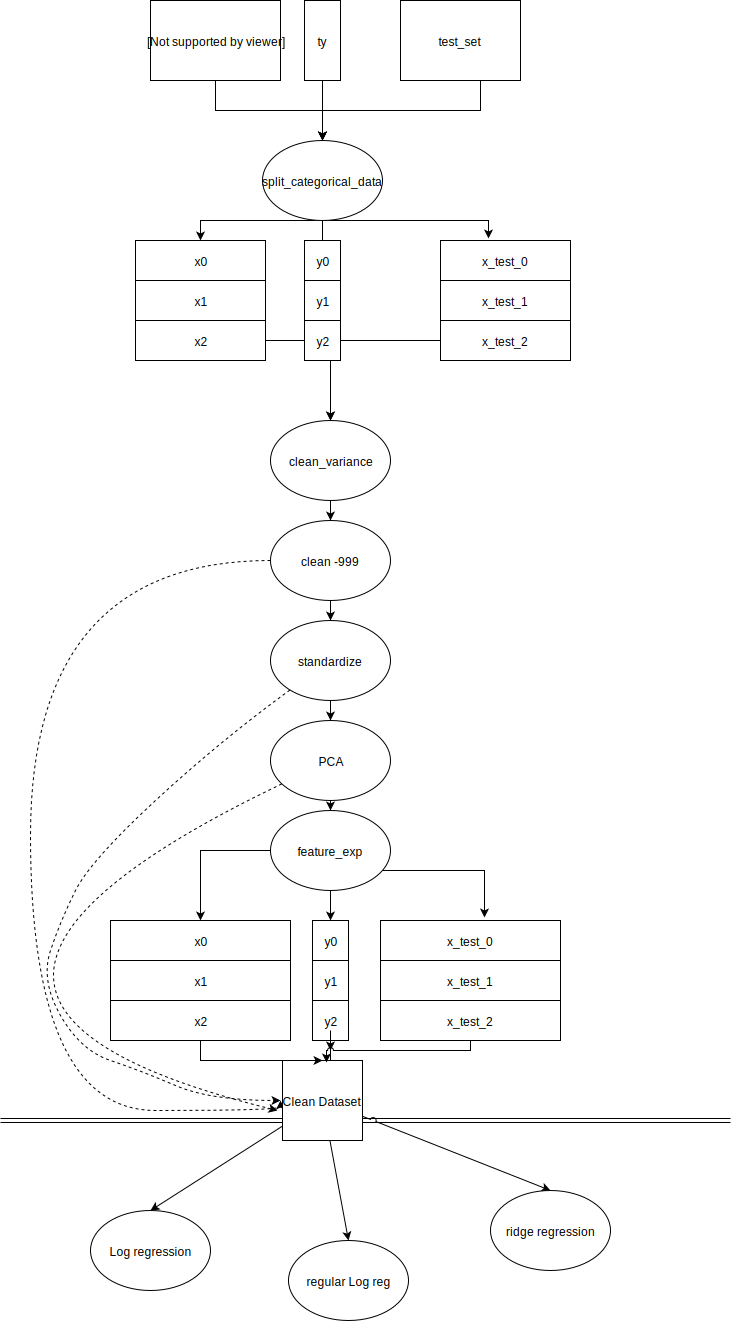

In [1]:
from IPython.core.display import SVG
SVG(filename='pipeline.svg')

## Loading the Data:

In [2]:
import logistic as log
import split as spl
import least_squares as lst
import helpers as hlp
import pre_processing as pre
import vizu as viz

In [3]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
DATA_TEST_PATH = '../data/test.csv'

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import pandas as pd # cannot use external libraries, just pandas for data exploration

In [5]:
y, tX, ids = hlp.load_csv_data(DATA_TRAIN_PATH)
_, tX_test, ids_test = hlp.load_csv_data(DATA_TEST_PATH)

In [6]:
print(tX.shape)
print(y.shape)

(250000, 30)
(250000,)


## Data exploration

In [8]:
data = pd.read_csv(DATA_TRAIN_PATH)
test_data = pd.read_csv(DATA_TEST_PATH)
dic = {'s':1,'b':-1}
data.Prediction = data.Prediction.map(dic)
test_data.Prediction = test_data.Prediction.map(dic)
data.head(10)

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,1,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,100001,-1,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226
2,100002,-1,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251
3,100003,-1,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,100004,-1,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
5,100005,-1,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,...,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
6,100006,1,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,...,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
7,100007,1,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,-999.000,-999.000,-999.000,30.638
8,100008,-1,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,...,0.024,129.804,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
9,100009,1,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,...,0.845,294.741,1,167.735,-2.767,-2.514,-999.000,-999.000,-999.000,167.735


In [9]:
mask = data.isin([-999]).any(axis = 1)
print(len(data[mask]))
print(len(data))

181886
250000


_The vast majoriy of our data has -999 values: we'd better handle it carefully_

In [9]:
#data.replace(to_replace = -999,value = np.nan, inplace = True)

In [10]:
#replace_val = np.nan
#tX = np.where(tX == -999,replace_val,tX)

In [11]:
std = np.nanstd(tX,axis = 0)
mean = np.nanmean(tX,axis = 0)

In [10]:
print('Train set size: {} samples x {} features'.format(pd.DataFrame(tX).shape[0], pd.DataFrame(tX).shape[1]))
print('Test set size: {} samples x {} features'.format(test_data.shape[0], pd.DataFrame(tX).shape[1]))

Train set size: 250000 samples x 30 features
Test set size: 568238 samples x 30 features


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 32 columns):
Id                             250000 non-null int64
Prediction                     250000 non-null int64
DER_mass_MMC                   250000 non-null float64
DER_mass_transverse_met_lep    250000 non-null float64
DER_mass_vis                   250000 non-null float64
DER_pt_h                       250000 non-null float64
DER_deltaeta_jet_jet           250000 non-null float64
DER_mass_jet_jet               250000 non-null float64
DER_prodeta_jet_jet            250000 non-null float64
DER_deltar_tau_lep             250000 non-null float64
DER_pt_tot                     250000 non-null float64
DER_sum_pt                     250000 non-null float64
DER_pt_ratio_lep_tau           250000 non-null float64
DER_met_phi_centrality         250000 non-null float64
DER_lep_eta_centrality         250000 non-null float64
PRI_tau_pt                     250000 non-null float64
PRI_tau_eta  

In [12]:
data.describe()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-0.314664,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,...,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591
std,72168.927986,0.949205,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,...,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662
min,100000.000000,-1.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,162499.750000,-1.000000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,...,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,224999.500000,-1.000000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,...,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500
75%,287499.250000,1.000000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750
max,349999.000000,1.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


#### Class separation - Justification

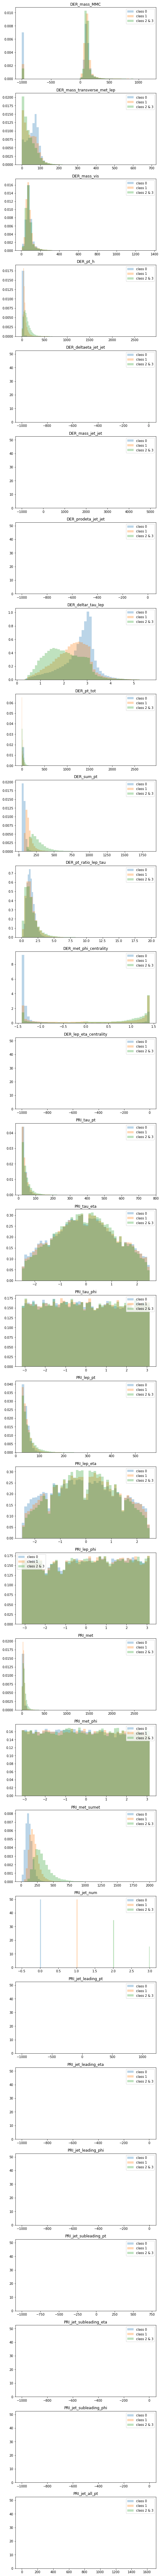

In [13]:
col_names = list(data.columns)[2:]

data_0 = data[data['PRI_jet_num'] == 0]
data_1 = data[data['PRI_jet_num'] == 1]
data_2 = data[data['PRI_jet_num'] >= 2]

fig, axes = plt.subplots(30, 1, figsize=(8, 150), sharex=False)
for idx, name in enumerate(col_names):    
    axes[idx].hist(data_0[name], bins=50, density=True, alpha=0.3, label='class 0')
    axes[idx].hist(data_1[name], bins=50, density=True, alpha=0.3, label='class 1')
    axes[idx].hist(data_2[name], bins=50, density=True, alpha=0.3, label='class 2 & 3')
    axes[idx].set_title(name)
    axes[idx].legend()

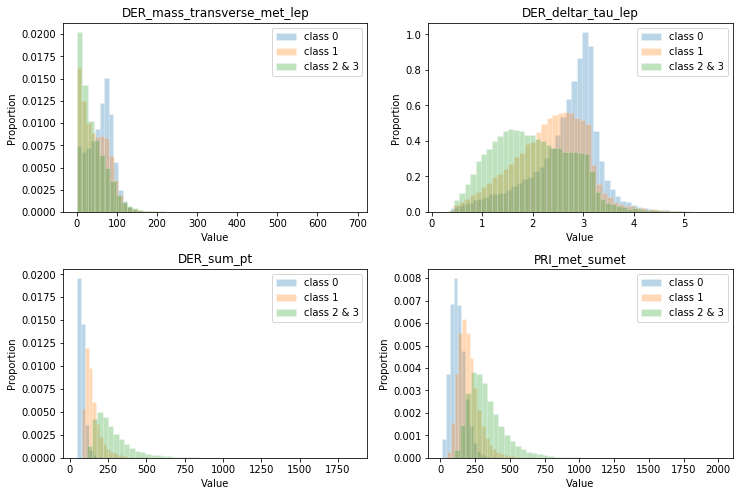

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(data_0['DER_mass_transverse_met_lep'], bins=50, density=True, alpha=0.3, label='class 0', edgecolor='w', lw=.5)
ax0.hist(data_1['DER_mass_transverse_met_lep'], bins=50, density=True, alpha=0.3, label='class 1', edgecolor='w', lw=.5)
ax0.hist(data_2['DER_mass_transverse_met_lep'], bins=50, density=True, alpha=0.3, label='class 2 & 3', edgecolor='w', lw=.5)
ax0.legend()
ax0.set_xlabel('Value', fontsize=10)
ax0.set_ylabel('Proportion', fontsize=10)
ax0.set_title('DER_mass_transverse_met_lep', fontsize=12)

ax1.hist(data_0['DER_deltar_tau_lep'], bins=50, density=True, alpha=0.3, label='class 0', edgecolor='w', lw=.5)
ax1.hist(data_1['DER_deltar_tau_lep'], bins=50, density=True, alpha=0.3, label='class 1', edgecolor='w', lw=.5)
ax1.hist(data_2['DER_deltar_tau_lep'], bins=50, density=True, alpha=0.3, label='class 2 & 3', edgecolor='w', lw=.5)
ax1.legend()
ax1.set_xlabel('Value', fontsize=10)
ax1.set_ylabel('Proportion', fontsize=10)
ax1.set_title('DER_deltar_tau_lep',fontsize=12)

ax2.hist(data_0['DER_sum_pt'], bins=50, density=True, alpha=0.3, label='class 0', edgecolor='w', lw=.5)
ax2.hist(data_1['DER_sum_pt'], bins=50, density=True, alpha=0.3, label='class 1', edgecolor='w', lw=.5)
ax2.hist(data_2['DER_sum_pt'], bins=50, density=True, alpha=0.3, label='class 2 & 3', edgecolor='w', lw=.5)
ax2.legend()
ax2.set_xlabel('Value', fontsize=10)
ax2.set_ylabel('Proportion', fontsize=10)
ax2.set_title('DER_sum_pt', fontsize=12)


ax3.hist(data_0['PRI_met_sumet'], bins=50, density=True, alpha=0.3, label='class 0', edgecolor='w', lw=.5)
ax3.hist(data_1['PRI_met_sumet'], bins=50, density=True, alpha=0.3, label='class 1', edgecolor='w', lw=.5)
ax3.hist(data_2['PRI_met_sumet'], bins=50, density=True, alpha=0.3, label='class 2 & 3', edgecolor='w', lw=.5)
ax3.legend()
#ax3.ticklabel_format(useMathText=True)
#ax3.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2e'))
ax3.set_xlabel('Value', fontsize=10)
ax3.set_ylabel('Proportion', fontsize=10)
ax3.set_title('PRI_met_sumet', fontsize=12)

fig.subplots_adjust(hspace=0.3)

In [16]:
#Save figure
fig.savefig("classes_comparison.png")

## Data Cleaning

In [17]:
#totrash before submit: we use pandas to know to which index PRI_jet_num does correspond.
np.where(data.columns.values == "PRI_jet_num")

(array([24], dtype=int64),)

In [18]:
data_trains = spl.split_categorical_data(tX,22,labels = y,split = True)
data_tests = spl.split_categorical_data(tX_test,22,split = True)

In [19]:
mean = 0
stdev = 0
clean_data_trains = []
clean_data_tests = []
degre_polys = [12,12,13]
for i,((x_train,y_train),(x_test,test_indx)) in enumerate(zip(data_trains,data_tests)):
    x_train,x_test = pre.clean_variance(x_train,x_test)
    
    x_train = pre.clean_value(x_train,-999,np.nan)
    x_test = pre.clean_value(x_test,-999,np.nan)
    
    """
    pre.PCA_visualize(x_train,label = i)
    
    mean,eigvecs,eigvals = pre.get_PCA(x_train)
    x_test = x_test - mean
    
    x_train = pre.reduce_PCA(eigvecs,x_train,10)
    x_test = pre.reduce_PCA(eigvecs,x_test,10)
    """
    
    x_train,mean,stdev =  pre.standardize_data(x_train)
    x_test,_,_ = pre.standardize_data(x_test, mean,stdev)
    
    x_train = pre.clean_value(x_train,np.nan,0,inplace = True)
    x_test = pre.clean_value(x_test,np.nan,0,inplace = True)
    
    
    x_train = pre.build_poly(x_train, degre_polys[i])
    x_test = pre.build_poly(x_test,degre_polys[i])
    x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
    x_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
    
    clean_data_trains.append((x_train,y_train))
    clean_data_tests.append((x_test,test_indx))

## Data Processing

_We now need to standardize the function so that they all take the same type of parameters as inputs_

In [20]:
init_w = np.random.rand(clean_data_tests[0][0].shape[1])
maxiters = 100
gamma = 0.01

#method 1
meth1 = lambda  y, x: lst.ridge_regression(y,x,5.17E-5)

if (len(clean_data_tests) > 1):
    init_w2 = np.random.rand(clean_data_tests[1][0].shape[1])
    #method 2
    #reg_log_reg = lambda y,x : log.reg_logistic_regression(y, x, lambda_, init_w2, maxiters, gamma)
    #meth2 = lambda  y, x: log.logistic_regression(y,x,init_w2,5,gamma)
    meth2 = lambda y,x : lst.ridge_regression(y,x,0.0013)

    init_w3 = np.random.rand(clean_data_tests[2][0].shape[1])
    #method 3
    lambda_ = 0.1
    meth3 = lambda y, x: lst.ridge_regression(y,x,0.001389)
    #log_reg3 = lambda  y, x: log.logistic_regression(y,x,init_w3,5,gamma)

methods = [meth1,meth2,meth3]

_At this point we try the different models defined in the cell above: to do so run the cell below, and check the obtained accuracies._

In [21]:
accuracies_group_means = []
accuracies_group_stds = []
for round_,((x_train,y_train),meth) in enumerate(zip(clean_data_trains,methods)):
    print("#################################")
    print("**********treating the {i}th group of data:**************".format(i = round_+1))
    acc_mean, acc_std = spl.k_fold_cv(y_train,x_train,5,meth)
    accuracies_group_means.append(acc_mean)
    accuracies_group_stds.append(acc_std)
print("done! Obtained accuracies:",[np.mean(i) for i in accuracies_group_means])

#################################
**********treating the 1th group of data:**************
1/5 round for the kfold:
obtained accur on 1/5 round of kfold:0.8464618156340706
2/5 round for the kfold:
obtained accur on 2/5 round of kfold:0.8408647350247711
3/5 round for the kfold:
obtained accur on 3/5 round of kfold:0.8421579421479332
4/5 round for the kfold:
obtained accur on 4/5 round of kfold:0.8450182655256968
5/5 round for the kfold:
obtained accur on 5/5 round of kfold:0.8399139268378122
#################################
**********treating the 2th group of data:**************
1/5 round for the kfold:
obtained accur on 1/5 round of kfold:0.8048104204281661
2/5 round for the kfold:
obtained accur on 2/5 round of kfold:0.8095944290412019
3/5 round for the kfold:
obtained accur on 3/5 round of kfold:0.8060481011025856
4/5 round for the kfold:
obtained accur on 4/5 round of kfold:0.8010832419885228
5/5 round for the kfold:
obtained accur on 5/5 round of kfold:0.8026307305435554
##########

## Optimization

#### Ridge

In [33]:
# for ridge: for every models test different lambdas and degrees
degrees = np.arange(1, 3)
lambdas = np.logspace(-5, 0, 2)

In [23]:
accuracies_tot = []

for idx_subset, (x_train, y_train) in enumerate(clean_data_trains):
    print('##### START SUBSET {} #####'.format(idx_subset))
    accuracies = np.zeros((len(lambdas), len(degrees)))
    for idx_deg, deg in enumerate(degrees):
        x_poly = pre.build_poly(x_train, deg)
        
        for idx_lambda, lambda_ in enumerate(lambdas):
            ridge = lambda y, x: lst.ridge_regression(y,x,lambda_)
            _, k_accuracies_test = spl.k_fold_cv(y_train, x_poly, 2, ridge)
            
            # update table
            accuracies[idx_lambda][idx_deg] = np.mean(k_accuracies_test)
    
    accuracies_tot.append(accuracies)
    print('##### END SUBSET {} #####'.format(idx_subset))


##### START SUBSET 0 #####
1/2 round for the kfold:
obtained accur on 1/2 round of kfold:0.8451036912482985
2/2 round for the kfold:
obtained accur on 2/2 round of kfold:0.8427847949236343
1/2 round for the kfold:
obtained accur on 1/2 round of kfold:0.8082512611097766
2/2 round for the kfold:
obtained accur on 2/2 round of kfold:0.8171827771883821
1/2 round for the kfold:
obtained accur on 1/2 round of kfold:0.6746937304828249
2/2 round for the kfold:
obtained accur on 2/2 round of kfold:0.5330384130352103
1/2 round for the kfold:
obtained accur on 1/2 round of kfold:0.7453158779726159
2/2 round for the kfold:
obtained accur on 2/2 round of kfold:0.5138218868226675
##### END SUBSET 0 #####
##### START SUBSET 1 #####
1/2 round for the kfold:
obtained accur on 1/2 round of kfold:0.8051170948106882
2/2 round for the kfold:
obtained accur on 2/2 round of kfold:0.8024347467244404
1/2 round for the kfold:
obtained accur on 1/2 round of kfold:0.7565769111730114
2/2 round for the kfold:
obtai

In [24]:
# save accuracies
import pickle

with open('acc_ridge.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(accuracies_tot, f)

Text(0.5, 1.0, 'Accuracy - subset 2')

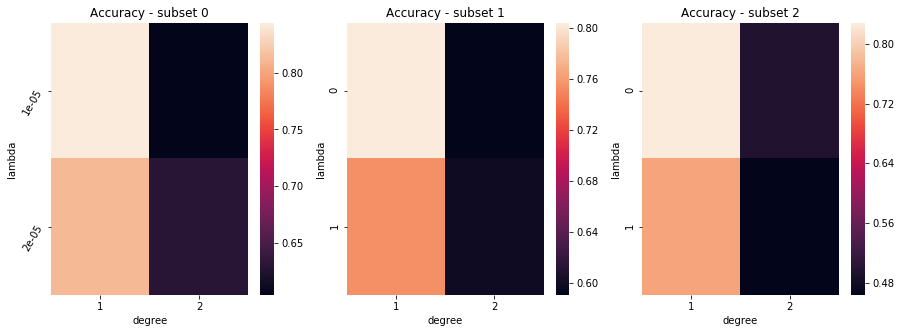

In [31]:
import seaborn as sns

plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
fig = sns.heatmap(accuracies_tot[0])
fig.set_yticklabels(np.round(lambdas, 5), rotation=60)
fig.set_xticklabels(degrees)
fig.set_xlabel('degree')
fig.set_ylabel('lambda')
fig.set_title('Accuracy - subset 0')
plt.subplot(1,3,2)
fig = sns.heatmap(accuracies_tot[1])
fig.set_xticklabels(degrees)
fig.set_xlabel('degree')
fig.set_ylabel('lambda')
fig.set_title('Accuracy - subset 1')
plt.subplot(1,3,3)
fig = sns.heatmap(accuracies_tot[2])
fig.set_xticklabels(degrees)
fig.set_xlabel('degree')
fig.set_ylabel('lambda')
fig.set_title('Accuracy - subset 2')

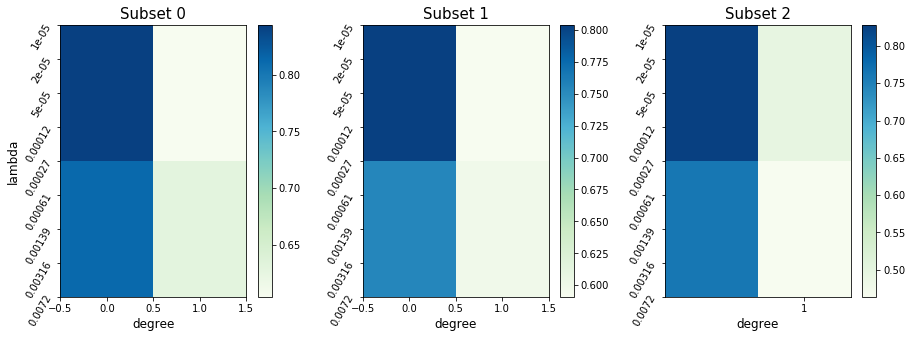

In [32]:
# plt version
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax0, ax1, ax2 = axes.flatten()

d0 = ax0.imshow(accuracies_tot[0], cmap='GnBu', aspect='auto')
ax0.set_yticklabels(np.round(lambdas, 5), rotation=60)
plt.xticks(degrees)
ax0.set_xlabel('degree', fontsize=12)
ax0.set_ylabel('lambda', fontsize=12)
ax0.set_title('Subset 0', fontsize=15)
fig.colorbar(d0, ax=ax0)

d1 = ax1.imshow(accuracies_tot[1], cmap='GnBu', aspect='auto')
ax1.set_yticklabels(np.round(lambdas, 5), rotation=60)
ax1.set_xlabel('degree', fontsize=12)
ax1.set_ylabel('')
ax1.set_title('Subset 1', fontsize=15)
fig.colorbar(d1, ax=ax1)

d2 = ax2.imshow(accuracies_tot[2], cmap='GnBu', aspect='auto')
ax2.set_yticklabels(np.round(lambdas, 5), rotation=60)
#plt.xticks(degrees)
ax2.set_xlabel('degree', fontsize=12)
ax2.set_ylabel('')
ax2.set_title('Subset 2', fontsize=15)
fig.colorbar(d2, ax=ax2)

plt.subplots_adjust(wspace=0.3)

In [29]:
#Save figure
fig.savefig("heatmaps.png")

In [30]:
# y: ↓ (lambdas), x: → (degree)
for nb, acc in enumerate(accuracies_tot):
    print('SUBSET {}'.format(nb))
    ymax = np.asscalar(np.where(acc == np.max(acc))[0])
    xmax = np.asscalar(np.where(acc == np.max(acc))[1])
    
    print('Best degree for subset {}: {}'.format(nb, degrees[xmax]))
    print('Best lambda for subset {}: {}'.format(nb, lambdas[ymax]))
    print('Accuracy: {}'.format(acc[ymax][xmax]))

SUBSET 0
Best degree for subset 0: 1
Best lambda for subset 0: 1e-05
Accuracy: 0.8439442430859665
SUBSET 1
Best degree for subset 1: 1
Best lambda for subset 1: 1e-05
Accuracy: 0.8037759207675643
SUBSET 2
Best degree for subset 2: 1
Best lambda for subset 2: 1e-05
Accuracy: 0.8281294866620443


## Visualization

1/4 round for the kfold:
obtained accur on 1/4 round of kfold:0.7982624709744576
2/4 round for the kfold:
obtained accur on 2/4 round of kfold:0.8394587236768356
3/4 round for the kfold:
obtained accur on 3/4 round of kfold:0.8424213307710785
4/4 round for the kfold:
obtained accur on 4/4 round of kfold:0.843788782577365
1/4 round for the kfold:
obtained accur on 1/4 round of kfold:0.8129954359836656
2/4 round for the kfold:
obtained accur on 2/4 round of kfold:0.8431820001601409
3/4 round for the kfold:
obtained accur on 3/4 round of kfold:0.8439827047802065
4/4 round for the kfold:
obtained accur on 4/4 round of kfold:0.8397453861243445
1/4 round for the kfold:


KeyboardInterrupt: 

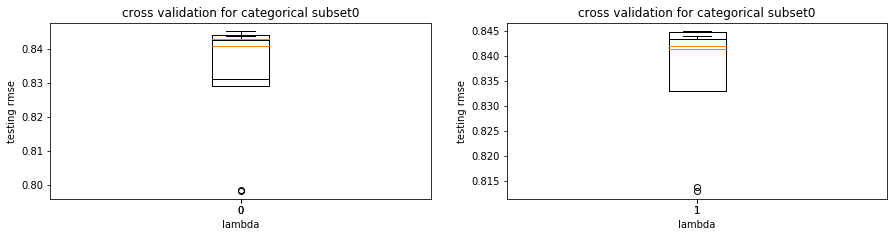

In [47]:
lambdas = np.logspace(-5, 0, 5)
plt.figure(1, figsize=(15, 11))
for idx_subset, (x_train, y_train) in enumerate(clean_data_trains):
    accuracy_train = np.zeros((len(lambdas)))
    accuracy_test = np.zeros((len(lambdas)))
    
    for idx_lambda, lambda_ in enumerate(lambdas):
            ridge = lambda y, x: lst.ridge_regression(y,x,lambda_)
            k_accuracies_train, k_accuracies_test = spl.k_fold_cv(y_train, x_train, 4, ridge, hlp.accuracy)
            plt.subplot(3,2,idx_lambda+1)
            plt.boxplot(k_accuracies_train, positions = [idx_lambda])
            plt.boxplot(k_accuracies_test, positions = [idx_lambda])
            plt.xlabel("lambda")
            plt.ylabel("testing rmse")
            plt.title("cross validation for categorical subset{i}".format(i=idx_subset))
            # update table
            accuracy_train[idx_lambda] = np.mean(k_accuracies_train)
            accuracy_test[idx_lambda] = np.mean(k_accuracies_test)
    viz.cross_validation_visualization(lambdas, accuracy_train, accuracy_test)

## Submission

_We now interpolate the data thanks to the model defined 2 cells higher..._

In [ ]:
y_submit = np.zeros(len(tX_test))
assert(len(tX_test) == sum([i[0].shape[0] for i in clean_data_tests]))
for (x_test,y_indx),(x_train,y_train),meth in zip(clean_data_tests,clean_data_trains,methods):
    w_fin,loss = meth(y_train,x_train)
    y_test = x_test @ w_fin
    y_test = [-1 if i < 0 else 1.0 for i in y_test]
    y_submit[y_indx] = y_test

_And finally save the results to csv._

In [ ]:
hlp.create_csv_submission(ids_test,y_submit,"anakin.csv")

## Put your useful trash here

In [ ]:
#trash random dataframe
np.random.seed(2)
df = pd.DataFrame(np.random.randint(-1002,-995,size =(3,4)), columns=list('ABCD'))
df.replace(to_replace = -999,value = np.nan)

In [ ]:
#Yann
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)